# Drag coefficient sensitivity wrt shape modifications

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [152]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.sparse as sp
import scipy.linalg as la

import ibmos as ib

## Description

In this notebook we consider the unsteady flow around a cylinder at $Re=200$ and determine the gradient of the RMS value of the drag coefficient with respect to changes in the geometry. To this end, we first integrate the equations forward in time, and use the adjoint method to propagate backwards sensitivity information.

For simplicity, we start from an instantaneous snapshot in the periodic regime, and compute the sensitivity over one vortex shedding period. In this way, all the snapshots can be stored in memory. In practical cases, one might want to use checkpointing techniques to reduce the amount of memory that is used.

# Initialization

In [139]:
recompute = False

In [3]:
%%time

# Numerical grid
s1 = ib.stretching(256, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
s2 = ib.stretching(128, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
x = np.r_[-s2[::-1], s1[1:]]

s = ib.stretching(192, 0.033, 0.20, int(0.5/0.033+16), 16, 16, 0.04)
y = np.r_[-s[::-1], s[1:]]

solver = ib.Solver(x, y, iRe=1/200.0, Co=0.015/0.033)

# Immersed boundaries
solver.set_solids(ib.shapes.cylinder("cylinder", 0, 0, 0.5, solver.dxmin))
#solver.plot_domain(figsize=(6, 5), xlim=(-2, 10), ylim=(-2, 2));

# Boundary conditions
uBC, vBC = solver.zero_boundary_conditions()
for k in range(4):
    uBC[k][:] = 1

sBC = ((np.zeros(solver.solids[0].l), np.zeros(solver.solids[0].l)), )

if recompute:
    # Prepare initial condition (uniform flow + vortex upstream the cylinder)
    u, v, p, *f = solver.reshape(*solver.unpack(solver.zero()))
    c, r, ϵ = -5, 1.0, 1.0
    u[:,:] = 1.0-ϵ*solver.fluid.u.y[:,np.newaxis]*np.exp(-((solver.fluid.u.x[np.newaxis,:]-c)**2 + solver.fluid.u.y[:,np.newaxis]**2)/r**2)
    v[:,:] = ϵ*(solver.fluid.v.x[np.newaxis,:]-c)*np.exp(-((solver.fluid.v.x[np.newaxis,:]-c)**2 + solver.fluid.v.y[:,np.newaxis]**2)/r**2)
    x0 = solver.pack(u, v, p, f)

    x, t, infodict = solver.steps(x0, uBC, vBC, sBC, outflowEast=True, 
                                  number=int(40.185/solver.dt), verbose=int(1.5/solver.dt))
    np.savez('23-CylinderRe200-x0.npz', x=x[-1], **infodict)
    x = x[-1]
else:
    x = np.load('23-CylinderRe200-x0.npz')['x']
    
x0 = x

solver.plot_field(x0, equal=True, xlim=(-2, 10), ylim=(-2, 2));

# Cost function and problem set-up

Here we consider the following cost on the left, which is equivalent to considering the cost function on the right:
$$ \frac{1}{t_2-t_1}\int_{t_1}^{t_2} C_d^2(t)\,\mathrm{d}t \propto \sum_{i=0}^n C_d(t_k)^2 = (Qf)^T (Qf)$$
In the above, $Q$ is the matrix whose rows are the flow snapshots from $t_1$ to $t_2$ sampled every $\Delta t$ and $f$ is a vector where the only non-zero components in the state vector are the entries that coincide with the momentum forcing in the horizontal direction. Then, $Q_{(k,:)}f$ is the drag coefficient at time $t_k$, $Qf$ is the time history of the drag coefficient, and $(Qf)^T (Qf)$ is a scalar that corresponds to the sum of the squares of the drag coefficient.

In [149]:
T = 5.10
k = int(T/solver.dt)
print("Number of snapshots:", k, "(requires", int(k*len(x0)*8/1024/1024), "Mb)")

Number of snapshots: 340 (requires 1134 Mb)


In [154]:
f = solver.zero()
f[solver.pEnd:solver.pEnd+solver.solids[0].l] = 2/np.sqrt(k)

# Forward step

In [78]:
Q, t, infodict = solver.steps(x0, uBC, vBC, sBC, outflowEast=False, saveEvery=1, number=k, verbose=int(1/solver.dt))

       k            t          x_2       dxdt_2  cylinder_fx  cylinder_fy 
     100  1.50000e+00  3.81283e+02  5.95367e+01  1.37352e+00  6.55592e-01 
     200  3.00000e+00  3.80448e+02  5.97314e+01  1.29276e+00 -2.96120e-01 
     300  4.50000e+00  3.81267e+02  5.91886e+01  1.36106e+00 -4.96884e-01 
     340  5.10000e+00  3.80811e+02  6.02767e+01  1.30613e+00 -7.71807e-02 


Perform some checks and make sure that the cost function is implemented correctly

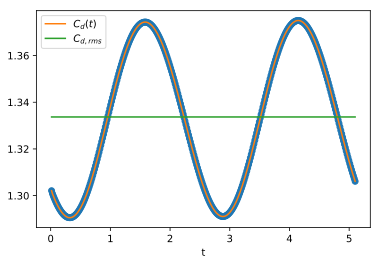

In [157]:
rmsCd = la.norm(Q@f)

plt.plot(t, np.sqrt(Q.shape[0])*Q@f, 'o-')
plt.plot(infodict['t'], infodict['cylinder_fx'], label=r'$C_d(t)$')
plt.plot([t[0], t[-1]], rmsCd*np.ones(2), label=r"$C_{d,rms}$")
plt.xlabel('t')
plt.legend();

# Backward step

In [161]:
A, B = solver.propagator(fractionalStep=False)
A, B = A[0], B[0]
iRx = solver.solver(A)[0]

In [166]:
import scipy.sparse as sp

In [187]:
Λ = np.zeros_like(Q)
###########
Λ[-1,:] = iRx(f)
###########
NT = -sp.block_diag([solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(Q[-2]))[:2], uBC, vBC),
                    sp.coo_matrix((len(f)-solver.pStart,)*2)]).T
Λ[-2,:] = iRx(Jx + (B+NT)@Λ[-1,:])

In [188]:
for k in range(Q.shape[0]-2)[::-1]:
    NTm1 = NT.copy()
    NT = -sp.block_diag([solver.fluid.linearized_advection(*solver.reshape(*solver.unpack(Q[k+1]))[:2], uBC, vBC), 
                         sp.coo_matrix((len(f)-solver.pStart,)*2)]).T
    Λ[k,:] = iRx(f + (B+1.5*NT)@Λ[k+1,:] - 0.5*NTm1@Λ[k+2,:])
    print(k, la.norm(Λ[k,:]))

337 7.506949697552122
336 7.594221286591822
335 7.739499364891713
334 7.934606782958796
333 8.170994966798938
332 8.438069692395965
331 8.723509149309931
330 9.014916847804457
329 9.301934435867842
328 9.577928263455451
327 9.840639067733392
326 10.091636286075317
325 10.33485969266395
324 10.57480751623644
323 10.814975125503
322 11.056983421030763
321 11.300544676201442
320 11.544106320917578
319 11.785795963659531
318 12.024235178209748
317 12.258906415457005
316 12.489989667310166
315 12.717829790639495
314 12.94234747994811
313 13.162707524860686
312 13.377416199105637
311 13.584805424164479
310 13.783673616573774
309 13.973776600464674
308 14.15592992873806
307 14.331663342755897
306 14.502574751822733
305 14.669669292893802
304 14.832975762505455
303 14.991605965932957
302 15.144221006002352
301 15.289684639013304
300 15.427601977983205
299 15.558499776208848
298 15.683575099221978
297 15.804142181562147
296 15.92104699995279
295 16.034329940729812
294 16.143294252358373
293 16.

# Animations

In [197]:
from IPython.display import HTML
from matplotlib import animation
%config InlineBackend.figure_format = 'png'

def init(quad):
    quad.set_array([])
    return quad,

def animate(i, x, quad):
    quad.set_array(solver.unpack(x[i])[0].ravel())
    return quad,

## Direct

In [199]:
plt.figure()
fig, ax = plt.subplots()
quad = ax.pcolormesh(solver.fluid.u.x, solver.fluid.u.y,
                     solver.reshape(*solver.unpack(Q[0]))[0],
                     rasterized=True, shading='gouraud')

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)
fig.tight_layout()

anim = animation.FuncAnimation(fig, lambda i: animate(i, Q, quad), 
                               init_func=lambda: init(quad), 
                               frames=len(Q), interval=15, blit=True)

CPU times: user 15min 23s, sys: 28.8 s, total: 15min 52s
Wall time: 2min


<Figure size 432x288 with 0 Axes>

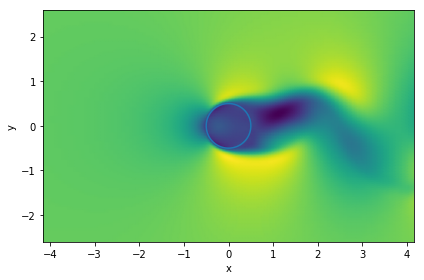

In [199]:
%time HTML(anim.to_html5_video())

## Adjoint

In [198]:
plt.figure()
fig, ax = plt.subplots()
quad = ax.pcolormesh(solver.fluid.u.x, solver.fluid.u.y,
                     solver.reshape(*solver.unpack(Λ[-1]))[0],
                     rasterized=True, shading='gouraud')

for solid in solver.solids:
    plt.plot(solid.ξ, solid.η)
    
ax.axis('equal')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_xlim(-4, 4)
ax.set_ylim(-2, 2)
fig.tight_layout()

anim = animation.FuncAnimation(fig, lambda i: animate(i, Λ[::-1], quad), 
                               init_func=lambda: init(quad), 
                               frames=len(Λ), interval=15, blit=True)

CPU times: user 15min 17s, sys: 28.2 s, total: 15min 46s
Wall time: 1min 53s


<Figure size 432x288 with 0 Axes>

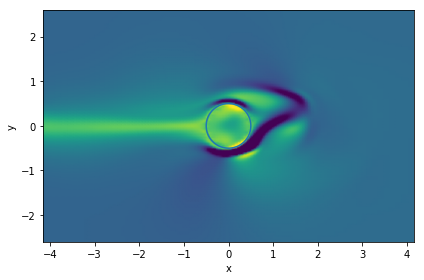

In [198]:
%time HTML(anim.to_html5_video())